<a href="https://colab.research.google.com/github/gulIbrahimi/Dog-Breed-Classification-with-Transfer-Learning-Project/blob/main/Dog_Breed_Classification_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
print("Matplotlib inline enabled")

import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

import warnings
warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE

Matplotlib inline enabled


Importing the dataset:

In [15]:
import zipfile

data_path = 'dog-breed-identification.zip'
print(zipfile.is_zipfile(data_path))  # Should print True

False


In [14]:
from zipfile import ZipFile
data_path = 'dog-breed-identification.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall()
    print('The data set has been extracted.')

BadZipFile: File is not a zip file

In [16]:
with open('dog-breed-identification.zip', 'rb') as f:
    print(f.read(200).decode(errors='ignore'))

PK-    ɦO%n
#͠/AvoD Z&s2]k?cL_-#'XcǧO\lsn{7a[o5?1ԴLn[=}Y>^


In [17]:
import os

print(f"Size in MB: {os.path.getsize('dog-breed-identification.zip') / 1024**2:.2f} MB")

Size in MB: 690.93 MB


In [18]:
!rm dog-breed-identification.zip

In [19]:
from google.colab import files
files.upload()  # Upload kaggle.json here if not already done

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"gulamiz","key":"419d1122e6ee4850f4a983ec3307d8fa"}'}

In [24]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !chmod 600 /content/kaggle.json

In [25]:
!kaggle competitions download -c dog-breed-identification


dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [26]:
# Now extract the dataset
from zipfile import ZipFile

with ZipFile("dog-breed-identification.zip", "r") as zip:
    zip.extractall()
    print("The dataset has been extracted.")

The dataset has been extracted.


## Exploratory Data Analysis

In [27]:
df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [28]:
df.shape

(10222, 2)

In [29]:
df['breed'].nunique()

120

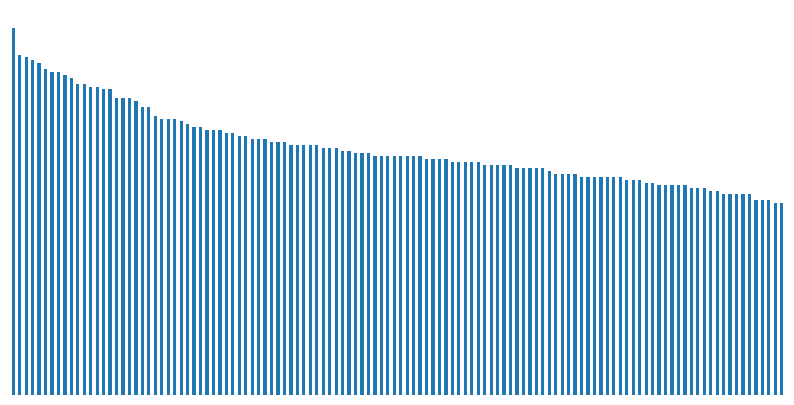

In [30]:
plt.figure(figsize=(10, 5))
df['breed'].value_counts().plot.bar()
plt.axis('off')
plt.show()

Here we can observe that there is a data imbalance between the classes of different breeds of dogs.

In [31]:
df['filepath'] = 'train/' + df['id'] + '.jpg'
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


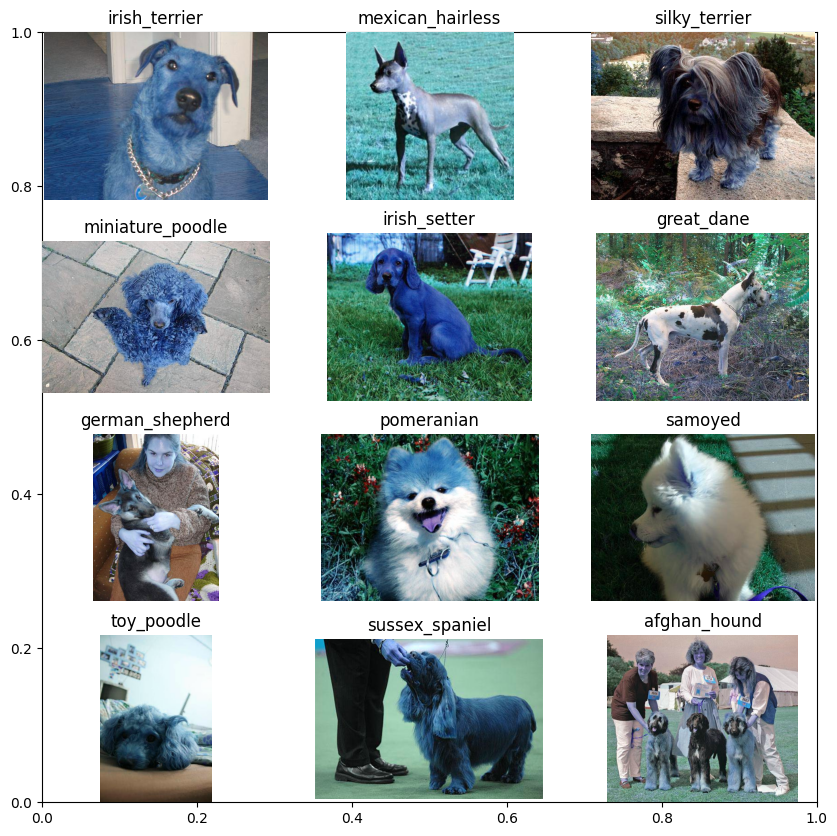

In [32]:
plt.subplots(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i+1)

    # Selecting a random image
    # index from the dataframe.
    k = np.random.randint(0, len(df))
    img = cv2.imread(df.loc[k, 'filepath'])
    plt.imshow(img)
    plt.title(df.loc[k, 'breed'])
    plt.axis('off')
plt.show()

The images are not of the same size which is natural as real-world images tend to be of different sizes and shapes. We will take care of this while loading and processing the images.

In [33]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,37,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,85,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,15,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,49,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


## Data Preparation

When working with large datasets in deep learning, memory limitations often prevent loading the entire dataset at once. To efficiently handle data loading and augmentation, tools like TensorFlow’s tf.data.Dataset and Albumentations are used to create optimized input pipelines and apply real-time image augmentations.

First, the dataset is split into training and validation sets, enabling model training on one subset and evaluation on another.

In [34]:
features = df['filepath']
target = df['breed']

X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)

X_train.shape, X_val.shape

((8688,), (1534,))

## Applying Image Augmentation
Below are some of the augmentations which we would like to have in our training data.

In [35]:
import albumentations as A

transforms_train = A.Compose([
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.7),
    A.CoarseDropout(p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1)
])

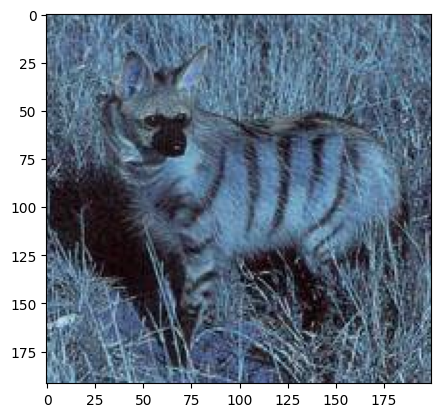

In [36]:
# Example
img = cv2.imread('train/00792e341f3c6eb33663e415d0715370.jpg')
plt.imshow(img)
plt.show()

Next, we apply several augmentations, such as VerticalFlip, HorizontalFlip, CoarseDropout, and CLAHE, and visualize the results:

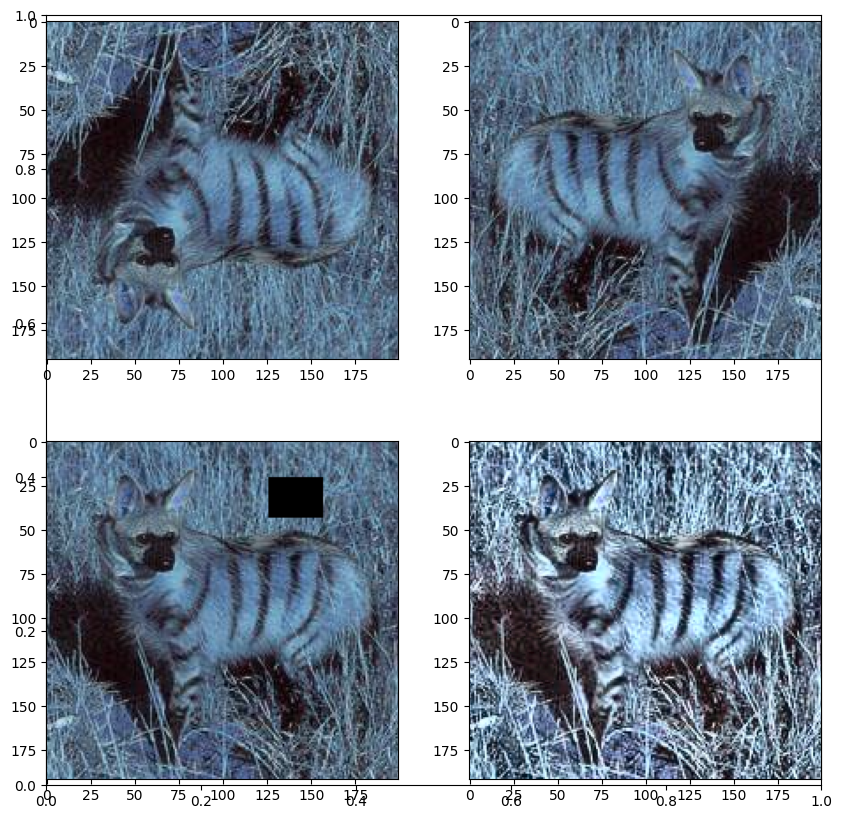

In [37]:
augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1),
            A.CoarseDropout(p=1), A.CLAHE(p=1)]

plt.subplots(figsize=(10, 10))
for i, aug in enumerate(augments):
    plt.subplot(2, 2, i+1)
    aug_img = aug(image=img)['image']
    plt.imshow(aug_img)
plt.show()

Different augmentations applied to the sample image, showing how the data transformation looks visually.

## Building the input pipeline
Below we have implemented some utility functions which will be used while building the input pipeline.

1. decode_image: This function will read the image from the path and resize them to be of the same size along with it will normalize as well. Finally, we will convert the labels into one_hot vectors as well.
2. process_data: This is the function that will be used to introduce image augmentation to the image.

In [39]:
# This function takes an image as input and applies image augmentation
# It uses  It uses the transforms_train object (presumably defined elsewhere using the Albumentations library) to perform the augmentations.
# The augmented image is then returned.
def aug_fn(img):
    aug_data = transforms_train(image=img)
    aug_img = aug_data['image']

    return aug_img

# his function is decorated with @tf.function, which means it will be compiled into a TensorFlow graph for potentially faster execution.
@tf.function
def process_data(img, label):
    aug_img = tf.numpy_function(aug_fn,
                                [img],
                                Tout=tf.float32)

    return img, label

# This function is responsible for reading an image from a given filepath, decoding it, resizing it to a fixed size ([128, 128]), and normalizing the pixel values to be between 0 and 1.
def decode_image(filepath, label=None):

    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0

    if label == None:
        return img

    return img, tf.one_hot(indices=label,
                           depth=120,
                           dtype=tf.float32)

We use functions above to implement our training data input pipeline and the validation data pipeline.

In [40]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train.values, Y_train.values))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(partial(process_data), num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)

)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val.values, Y_val.values))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

We must observe here that we do not apply img data augmentation on validation or testing data.

In [41]:
for img, label in train_ds.take(1):
    print(img.shape, label.shape)

(32, 128, 128, 3) (32, 120)


From here we can confirm that the images have been converted into (128, 128) shapes and batches of 64 images have been formed.

## Model Building Using Transfer Learning

1. **Load Pre-trained InceptionV3 Model**
We first load the **InceptionV3 model** from TensorFlow's Keras API with the weights pre-trained on ImageNet. The include_top=False argument excludes the fully connected layers at the top of the network, allowing us to customize the final layers for our task.

In [43]:
from tensorflow.keras.applications import InceptionV3

pre_trained_model = InceptionV3(input_shape=(128, 128, 3),
                                include_top=False,
                                weights='imagenet',
                                pooling='avg')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


The model is successfully loaded with the weights from ImageNet, and we can now access the feature extraction layers.

2. **Inspect the model's depth**
InceptionV3 is a deep network with many layers, which makes it effective in learning complex features from images. Let's check the number of layers in this pre-trained model.

In [44]:
len(pre_trained_model.layers)

312

This deep architecture, consisting of 312 layers, makes it highly efficient at extracting detailed features from images.

3. Freeze Pre-Trained Layers

Since the convolutional layers of the InceptionV3 model have already been trained on millions of images, we freeze these layers so that their weights are not updated during our fine-tuning process.

In [46]:
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
# Access the output shape from the output tensor of the layer
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


This tell us that the last convolutional layer outputs a 6x6 grid of features with 768 channels.

5. Define the Custom Model Architecture

Using the Keras Functional API, we can build a custom classification head on top of the pre-trained model. This includes flattening the output, adding fully connected layers, BatchNormalization for stable training, Dropout for regularization, and finally, an output layer with softmax activation for multi-class classification.

In [47]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

# Model Compilation
model.compile(
	optimizer='adam',
	loss=keras.losses.CategoricalCrossentropy(from_logits=True),
	metrics=[tf.keras.metrics.AUC()]
)

6. Implement Callbacks

Callbacks are used to monitor the model's performance during training. We use the following callbacks:

- EarlyStopping: Stops training if validation AUC doesn't improve for 3 consecutive epochs, preventing overfitting.
- ReduceLROnPlateau: Reduces the learning rate when the validation loss plateaus, helping the model converge better.
- Custom Callback: Stops training if the validation AUC exceeds 0.99.

In [48]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_auc') is not None and logs.get('val_auc') > 0.99:
			print('\n Validation accuracy has reached upto 90% so, stopping further training.')
			self.model.stop_training = True

es = EarlyStopping(patience=3,
                monitor='val_auc',
                restore_best_weights=True,
                mode='max')

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)

## Train the model
We train the model using the fit() method with training and validation datasets, a maximum of 50 epochs, and the callbacks defined above.

In [51]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    verbose=1,
                    callbacks=[es, lr, myCallback()])

Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - auc: 0.9994 - loss: 0.4820 - val_auc: 0.8920 - val_loss: 2.7707 - learning_rate: 0.0010
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - auc: 0.9997 - loss: 0.2809 - val_auc: 0.9037 - val_loss: 2.5632 - learning_rate: 0.0010
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - auc: 0.9999 - loss: 0.1296 - val_auc: 0.9077 - val_loss: 2.6151 - learning_rate: 0.0010
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - auc: 0.9999 - loss: 0.0789
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
272/272 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - auc: 0.9999 - loss: 0.0789 - val_auc: 0.8907 - val_loss: 2.7115 - learning_rate: 0.0010
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - auc: 1.0000 - loss: 0.0475 - val_auc: 0.9065 - val_loss: 2.5187 - learning_rate: 5.0000e-04
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - auc: 1.0000 - loss: 0.0242 - val_auc: 0.9053 - val_loss: 2.5155 - learning_rate: 

The output will display the training and validation loss, as well as the AUC score after each epoch. If the validation AUC exceeds 0.99, the training will stop early.


## Evaluate the Model
Once the model is trained, we evaluate its performance on the test dataset. We visualize the training history to observe the model's learning curve and make sure it has converged effectively.

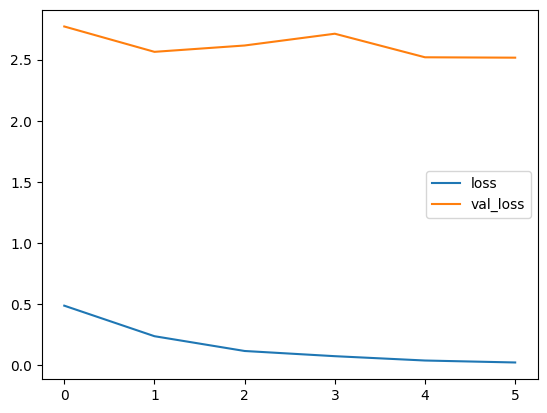

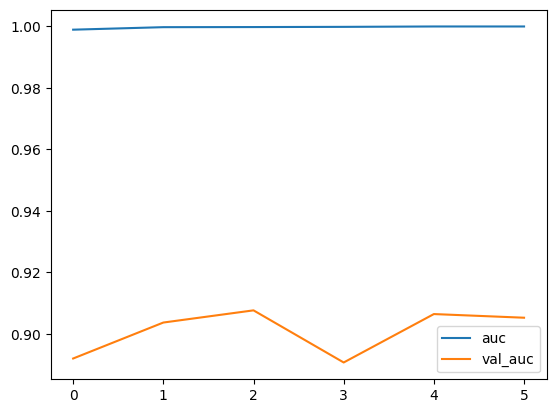

In [52]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['auc', 'val_auc']].plot()
plt.show()

The training and validation AUC curves are plotted, showing how the model's performance evolved over time. The test loss and test AUC are displayed, providing insight into how well the model generalizes to unseen data.